### Introduction to Preprocessing and Training Stage 

## Preprocessing and Training

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from library.sb_utils import save_file

### Load Data

In [2]:
df = pd.read_csv('../data/df_for_modeling_no_decay_weighting.csv')
df.head()

,P_Date,P_Date_str,IS1_Completed,Comp_Date,Comp_Date_str,Comp_Hr,Solve_day_phase,IS_per_sdp_avg_past_diff_from_RPB,DOW,DOW_num,...,Circle_Count,Shade_Count,Unusual_Sym,Black_Square_Fill,Outside_Grid,Unchecked_Sq,Uniclue,Duplicate_Answers,Quantum,Wordplay
0,2024-02-17 00:00:00,2024-02-17,1,2024-02-17 07:49:40,2024-02-17,7,2.0,-6.40,Saturday,7.0,...,0,0,0,0,0,0,0,0,0,4.0
1,2024-02-16 00:00:00,2024-02-16,1,2024-02-16 07:09:58,2024-02-16,7,2.0,-6.37,Friday,6.0,...,0,0,0,0,0,0,0,0,0,8.0
2,2024-02-15 00:00:00,2024-02-15,1,2024-02-15 06:54:05,2024-02-15,6,2.0,-6.40,Thursday,5.0,...,5,0,1,0,0,0,0,0,0,4.0
3,2024-02-14 00:00:00,2024-02-14,1,2024-02-14 07:15:40,2024-02-14,7,2.0,-6.42,Wednesday,4.0,...,0,0,1,0,0,0,0,0,0,2.0
4,2024-02-13 00:00:00,2024-02-13,1,2024-02-13 07:18:49,2024-02-13,7,2.0,-6.44,Tuesday,3.0,...,0,0,1,0,0,0,0,0,0,2.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 965 entries, 0 to 964
Data columns (total 50 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   P_Date                                965 non-null    object 
 1   P_Date_str                            965 non-null    object 
 2   IS1_Completed                         965 non-null    int64  
 3   Comp_Date                             965 non-null    object 
 4   Comp_Date_str                         965 non-null    object 
 5   Comp_Hr                               965 non-null    int64  
 6   Solve_day_phase                       965 non-null    float64
 7   IS_per_sdp_avg_past_diff_from_RPB     964 non-null    float64
 8   DOW                                   965 non-null    object 
 9   DOW_num                               965 non-null    float64
 10  GMST(m)                               965 non-null    float64
 11  IS1_ST(m)          

### Filter Data

In [4]:
df['DOW_num'].unique()

array([7., 6., 5., 4., 3., 2., 1.])

In [5]:
df_filter = df.copy()

In [57]:
#Remove the first solve period (2021)
# NOTE: This was done at the end of the feature generation stage for IS1
# df_filter = df_filter[df_filter['Comp_Date_str'].str.contains("2022|2023|2024")]

In [6]:
#Filter out Sunday
df_filter =df_filter[df_filter["DOW_num"]!=1]

In [7]:
# Strip down to only the features we need to benchmark and the target feature
df_filter = df_filter[['overall_day_mean_IST(m)', 'IS1_ST(m)']]

In [8]:
df_filter[['IS1_ST(m)']].mean()

IS1_ST(m)    11.0907
dtype: float64

In [9]:
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828 entries, 0 to 964
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   overall_day_mean_IST(m)  828 non-null    float64
 1   IS1_ST(m)                828 non-null    float64
dtypes: float64(2)
memory usage: 19.4 KB


Creating df variants with only the columns we will need to generate the benchmark models 

In [10]:
df_model1 = df_filter[['overall_day_mean_IST(m)','IS1_ST(m)']]

In [11]:
#df_model2 = df_filter[['IS1_ST(m)','overall_day_mean_IST(m)']]

In [12]:
df_model1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828 entries, 0 to 964
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   overall_day_mean_IST(m)  828 non-null    float64
 1   IS1_ST(m)                828 non-null    float64
dtypes: float64(2)
memory usage: 19.4 KB


### Train Test Split

In [13]:
len(df_model1) * .80, len(df_model1) * .20

(662.4000000000001, 165.60000000000002)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_model1.drop(columns='IS1_ST(m)'), 
                                                    df_model1['IS1_ST(m)'], test_size=0.20, 
                                                    random_state=47)

In [15]:
y_train.shape, y_test.shape

((662,), (166,))

In [16]:
y_train

403     7.916667
202     4.800000
378    28.700000
369     5.666667
381    12.083333
         ...    
804     8.966667
681     6.800000
309    12.833333
391     5.666667
158    10.216667
Name: IS1_ST(m), Length: 662, dtype: float64

In [17]:
X_train.shape, X_test.shape

((662, 1), (166, 1))

### Pre-Modeling: IS1 Mean Solve Time Across All 15x15 Puzzles as Per Solve (IS1_ST) Predictor (aka "Dummy Model")

In [18]:
#Target feature (IS1_ST(m)) training set mean
train_mean = y_train.mean()
train_mean

10.948439073514596

In [19]:
#Fitting dummy regressor to training data (from sklearn). Outputs the training set mean.
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[10.94843907]])

In [20]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([10.94843907, 10.94843907, 10.94843907, 10.94843907, 10.94843907])

In [21]:
y_te_pred = train_mean * np.ones(len(y_test))

#### R-Squared (COD)

In [22]:
#Compute R-squared for target mean on training set (will be zero, since we are calculating mean on training set), and on test set (should be slightly different from zero)
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.011962731883880418)

proportion of the variance for a dependent variable that's explained by our features. It's close to zero for the dummy model as expected.

#### Mean Absolute Error (MAE)

In [23]:
MAEs_dummy = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
MAEs_dummy

(4.369019389502956, 4.479643650129217)

#### Mean Squared Error (MSE)

In [24]:
#Calculate the Mean Squared Error (average of the square of the errors)
MSEs_dummy = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
MSEs_dummy

(32.13797087670085, 42.594435030917545)

#### Root Mean Squared Error (RMSE)

In [25]:
RMSEs_dummy = np.sqrt(mean_squared_error(y_train, y_tr_pred)), np.sqrt(mean_squared_error(y_test, y_te_pred))
RMSEs_dummy

(5.669036150590403, 6.526441222513043)

On average, we might expect to be off by around 5.67 minutes on training set data and 6.53 minutes on test data if you guessed the IS1 solve time on a given 15x15 puzzle based simply on an average of known values.

Now instead of just guessing with the training set mean across all puzzle days, let's use a few benchmarks that at least take into consideration the default difficulty of a given puzzle based on it's puzzle day.

### Benchmark Linear Model 1: Puzzle Day-Specific, Whole-Sample Mean Global Median Solver (IS1) Solve Time as Sole Predictor of Individual Solve Times (IS1_STs)

In [27]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 662 entries, 403 to 158
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   overall_day_mean_IST(m)  662 non-null    float64
dtypes: float64(1)
memory usage: 10.3 KB


In [28]:
#Filter existing train-test split down to just the ranking columns (train)
#X_train_ranking = X_train[["p_rank", "p_rank_pts", "p_log_rank", "p_opp_rank_diff", "p_opp_rank_pts_diff", "p_opp_log_rank_diff"]]

In [29]:
#Filter existing train-test split down to just the ranking columns (test)
#X_test_ranking = X_test[["p_rank", "p_rank_pts", "p_log_rank", "p_opp_rank_diff", "p_opp_rank_pts_diff", "p_opp_log_rank_diff"]]

In [30]:
lr_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [31]:
#Dict of available parameters for linear regression pipe
lr_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [32]:
#Define search grid parameters
k = [k+1 for k in range(len(X_train.columns))]

grid_params = {
    'standardscaler': [StandardScaler(), None],
    'simpleimputer__strategy': ['mean', 'median'],
    'selectkbest__k': k
}

In [33]:
#Call `GridSearchCV` with linear regression pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=grid_params, cv=5)

In [34]:
#Conduct grid search for this ranking-restricted model. 
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x0000029E74B13310>)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'selectkbest__k': [1],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [35]:
#Best params from grid search for this ranking-restricted model
lr_grid_cv.best_params_

{'selectkbest__k': 1,
 'simpleimputer__strategy': 'mean',
 'standardscaler': None}

#### K Best Features Visualization

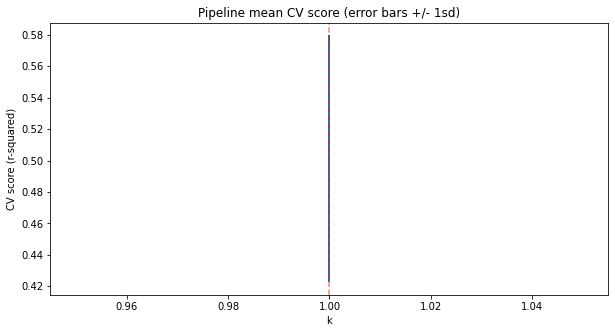

In [36]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

### Benchmark Model 1 Metrics

#### R-squared (COD)

In [37]:
#Cross-validation defaults to R^2 metric for scoring regression
lr_best_cv_results = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, cv=5)
lr_best_scores = lr_best_cv_results['test_score']
lr_best_scores

array([0.51703214, 0.35476826, 0.53317167, 0.50895401, 0.5912466 ])

In [38]:
#Training set CV mean and std
np.mean(lr_best_scores), np.std(lr_best_scores)

(0.5010345348047927, 0.07859195652606324)

#### Mean Absolute Error (MAE)

In [39]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [40]:
# Training set MAE and STD 
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
MAE_LR_train = lr_mae_mean, lr_mae_std
MAE_LR_train

(2.576266776495212, 0.2683951990433144)

In [41]:
# Test set mean
MAE_LR_test = mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MAE_LR_test

2.9063023401098707

#### Mean Squared Error (MSE)

In [42]:
lr_neg_mse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [43]:
#Training set CV mean and std
lr_mse_mean = np.mean(-1 * lr_neg_mse['test_score'])
lr_mse_std = np.std(-1 * lr_neg_mse['test_score'])
MSE_LR_train = lr_mse_mean, lr_mse_std
MSE_LR_train

(15.67633040612509, 3.2627669069138436)

In [44]:
# Test set mean
MSE_LR_test = mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MSE_LR_test

24.251540528755836

#### Root Mean Square Error (RMSE)

In [45]:
lr_neg_rmse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [46]:
#Training set CV mean and std
lr_rmse_mean = np.mean(-1 * lr_neg_rmse['test_score'])
lr_rmse_std = np.std(-1 * lr_neg_rmse['test_score'])
RMSE_LR_train = lr_rmse_mean, lr_rmse_std
RMSE_LR_train

(3.9348477610902455, 0.4396629426824221)

In [47]:
# Test set mean
RMSE_LR_test = np.sqrt(mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test)))
RMSE_LR_test

4.9245853154104084

### Best Linear Model Feature Importance

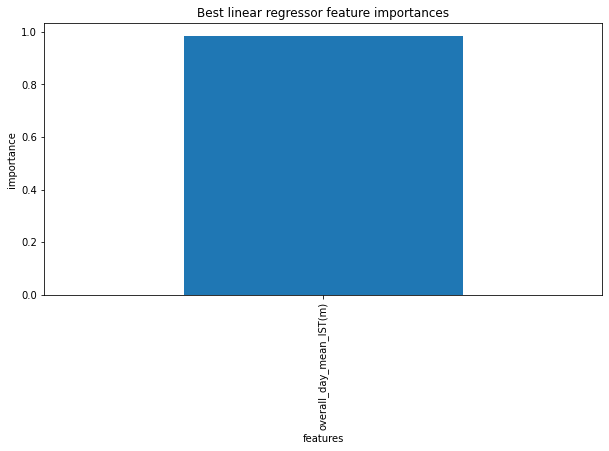

In [48]:
#Plots a barplot of the linear regressor feature importances,
#assigning the `feature_importances_` attribute of 
#`lv_grid_cv.best_estimator_.named_steps.linearregression` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
plt.subplots(figsize=(10, 5))
imps = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
lr_feat_imps = pd.Series(imps, index=X_train.columns[selected]).sort_values(ascending=False)
lr_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best linear regressor feature importances');

### Save Best Linear Model Object From Pipeline

In [49]:
# save the best linear model
best_model = lr_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

modelpath = '../models'
save_file(best_model, 'IS1_benchmark_linearmodel.pkl', modelpath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../models\IS1_benchmark_linearmodel.pkl"


### Save Prediction Metrics from Dummy Model and Benchmark Model 1

In [50]:
# save other data for model comparisons in machine learning model stage
comp_data_from3_IST = (MAEs_dummy, MSEs_dummy, RMSEs_dummy, MAE_LR_train, MAE_LR_test, MSE_LR_train, MSE_LR_test, RMSE_LR_train, RMSE_LR_test)
with open('../data/IST_benchmark.pickle', 'wb') as f:
    pickle.dump(comp_data_from3_IST, f)

### Conclusions

Target feature predicted is IS1 raw solve time in minutes. Measure reported here is RMSE.

* Dummy Model: 5.67 Train; 6.53 Test    
* Linear Model Using IS1 Sample Mean Per Puzzle Day as Only Predictive Feature: 3.93 (0.44) Train; 4.92 Test

The benchmark model wildly outperforms the dummy model, which should be no surprise since it's the (whole sample) puzzle day specific mean. 